# I. Algorithm

In [10]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [58]:
# Defining the Euclidean distance function - Will Be Default
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Manhattan Distance 
def manhattan_distance(point1, point2):
    return np.abs(point1[0]-point2[0]) + np.abs(point1[1]-point2[1])

# Returns the coordinates of the centroid given the 2D np array cluster, which lists the coordinates of the points in a cluster
def calculate_centroid(cluster):
    centroid = np.mean(cluster, axis=0)
    return centroid

# Given data and centroids, assigns each point to an array in the output clusters
def assign_clusters(data, centroids, distance):
    clusters = [[] for i in centroids] # Initialize empty list of lists for clusters
    for point in data:
        distances = [distance(point, centroid) for centroid in centroids]
        closest_index = np.argmin(distances)
        clusters[closest_index].append(point)
    return clusters

# Returns the coordinates of the new centroids
def update_centroids(data, clusters):
    new_centroids = []
    for cluster in clusters:
        # Case where no points are assigned to a centroid point
        if len(cluster) == 0:
            random_index = np.random.choice(len(data),1)
            new_centroid = data[random_index][0]
        else:
            new_centroid = calculate_centroid(np.array(cluster))
        new_centroids.append(new_centroid)
    return np.array(new_centroids)

# Checks if newly calculated centroids have changed within a tolerance level 
def has_converged(old_centroids, new_centroids, tol=1e-4):
    """
    Check for convergence in k-means cluster

    Inputs: old_centroids: numpy array with coordinates for old_centroids
            new_centroids: numpy array with coordinates for new_centroids
            tol: tolerance for convergence
    Output: True if difference between new and old centroids are all within the tolerance
    """
    # Compute the distance between corresponding centroids
    centroid_diff = np.linalg.norm(old_centroids - new_centroids, axis=1)
    
    # Check if all the distances are below the tolerance
    return np.all(centroid_diff < tol)

# Puts all the helper functions together and implements k-means clustering

def k_means(data, k, distance_function, max_iters = 100):
    """
    Performs k-means clustering 

    Inputs: data: numpy array where each row is a data point
            k: The number of clusters
            max_iters: Max number of iterations of algorithm, default is 100
            distance: the distance function used
    Output: centroids: numpy array where each row is a centroid of a cluster
            clusters: a list of lists that gives the coordinates of each point in the cluster
    """

    indices = np.random.choice(len(data), k, replace=False)
    centroids = data[indices]

    for iter in range(max_iters):
        # Assign clusters and update centroids
        clusters = assign_clusters(data, centroids, distance_function)
        new_centroids = update_centroids(data, clusters)
        if has_converged(centroids, new_centroids):
            break
        centroids = new_centroids

    return centroids, clusters

# Computes the Within-Cluster Sum of Squares

def compute_wcss(clusters, centroids, distance_function):
    """
    Computes the Within-Cluster Sum of Squares (WCSS)
    
    Inputs:
        clusters: List of clusters, each containing the points in that cluster.
        centroids: numpy array that gives centroids of the clusters 
    
    Output:
        The WCSS value.
    """
    wcss = 0
    k = len(clusters)  # Number of clusters
    
    for i in range(k):
        cluster_points = clusters[i]  # Points in the i-th cluster
        centroid = centroids[i]  # Centroid of the i-th cluster
        
        # Calculate the sum of squared distances from each point in the cluster to the centroid
        cluster_wcss = np.sum([distance_function(point, centroid) ** 2 for point in cluster_points])
        wcss += cluster_wcss
    
    return wcss

def plot_clusters(data, clusters, centroids):
    """
    Plots the data points with each cluster having its own color and centroids marked.

    Inputs:
        data: numpy array of data points 
        clusters: list of clusters, where each cluster is a list of points assigned to that cluster
        centroids: numpy array of centroids (e.g., (k, 2) for 2D centroids)
    """
    # Number of clusters
    k = len(clusters)

    # Generate colors for each cluster
    colors = plt.cm.get_cmap('tab20', k) 

    # Plot each cluster with a different color
    for i in range(k):
        cluster_points = np.array(clusters[i])
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colors(i)], label=f'Cluster {i+1}', s=30)

    # Plot the centroids as red "x" points
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100, label='Centroids')

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Clusters of Roller Coasters with k = {k}')

    # Display the plot
    plt.show()


# II. Application to Data Set

Suppose you are planning a road trip to visit some roller coasters in the United States. You want to hit the most amount of roller coasters while also being efficient with travel distance. Where should you go?

To answer this question, we will use k-Means Clustering to cluster our roller coasters into clusters based on their coordinate location (longitude and latitude).

First, we will do some data cleaning.

In [43]:
coaster_data = pd.read_csv("../coaster_db.csv")

cleaned_data = coaster_data[['coaster_name','latitude','longitude']]

cleaned_data.dropna

cleaned_data.head(5)

,coaster_name,latitude,longitude
0,Switchback Railway,40.5740,-73.9780
1,Flip Flap Railway,40.5780,-73.9790
2,Switchback Railway (Euclid Beach Park),41.5800,-81.5700
3,Loop the Loop (Coney Island),40.5745,-73.9780
4,Loop the Loop (Young's Pier),39.3538,-74.4342


Our data does not explicitly say if a roller coaster is in the United States or not. However, we do know that continental U.S. is bound between latitudes from roughly 25° to 49° North and longitudes from 60° to 125° West. Note that West corresponds to negative longitudes.

In [44]:
# Restricting Data to U.S. roller coasters based on longitude and latitude
continental_us = cleaned_data[
    (cleaned_data['latitude'] >= 25) & (cleaned_data['latitude'] <= 49) &
    (cleaned_data['longitude'] >= -125) & (cleaned_data['longitude'] <= -60)
]

print(f"The number of roller coasters in the Continental US is {len(continental_us)}.")

The number of roller coasters in Continental US is 514.


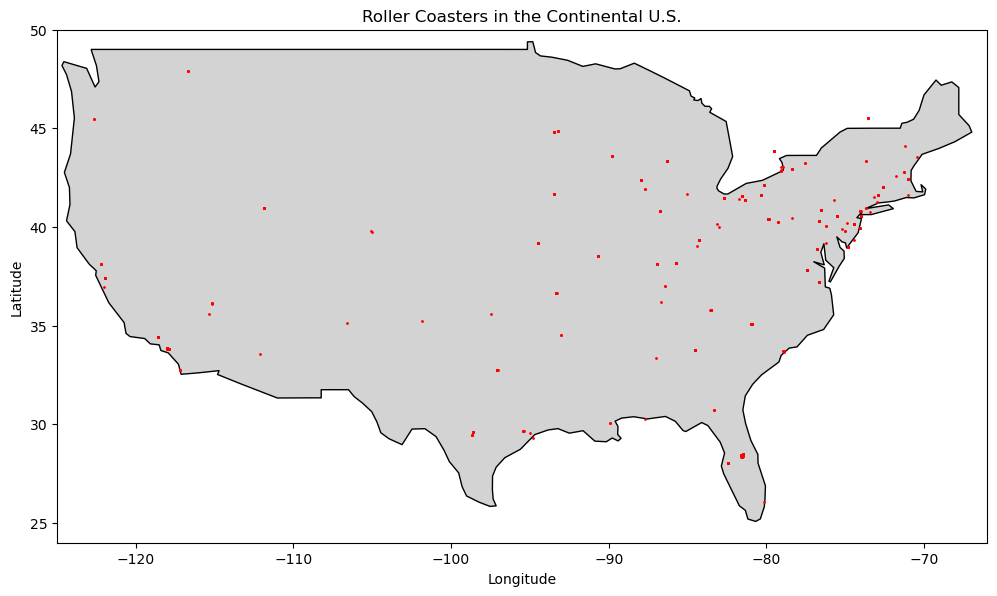

In [45]:
# Create geometry from longitude and latitude
geometry = [Point(xy) for xy in zip(continental_us['longitude'], continental_us['latitude'])]
geo_df = gpd.GeoDataFrame(continental_us, geometry=geometry, crs='EPSG:4326')  # WGS 84

# Load the built-in low-resolution world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for United States
usa = world[world['name'] == 'United States of America']

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
usa.plot(ax=ax, color='lightgray', edgecolor='black')
geo_df.plot(ax=ax, color='red', markersize=1)

# Set bounds for continental U.S.
ax.set_xlim(-125, -66)   # Longitude
ax.set_ylim(24, 50)      # Latitude

plt.title('Roller Coasters in the Continental U.S.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


As you can see, roller coasters are sparsely located around the United States. However, there is definitley a lot of clusters in the Northeast and the Midwest. Now, let's apply the k-Means-Clustering Algorithm. We will apply the elbow-method to determine the optimal $k$ value.

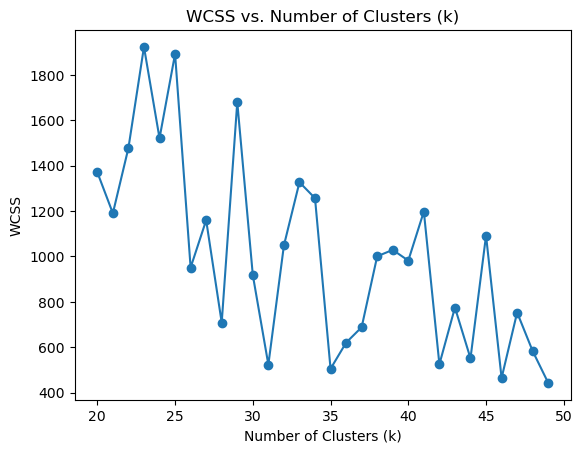

In [67]:
us_coasters_coordinates = continental_us[['longitude','latitude']].to_numpy() # Only Looking at Coordinates
# Elbow Method

wcss_values = []

for k_value in range(20,50):
    # Running algorithm for each value of k
    us_centroids_k, us_clusters_k = k_means(us_coasters_coordinates, k = k_value, distance_function=euclidean_distance, max_iters = 100)
    wcss_k = compute_wcss(us_clusters_k, us_centroids_k, euclidean_distance)
    wcss_values.append(wcss_k)

# Plotting
plt.plot(range(20, 50), wcss_values, marker='o')
plt.title('WCSS vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

The Elbow Method doesn't exactly work the best for our data. There's a lot of fluctuations even though the WCSS decreases generally as you increase the number of clusters. Based on this, we can choose $k$ to be 31. This is where the WCSS value decreases significally from previous $k$ values.

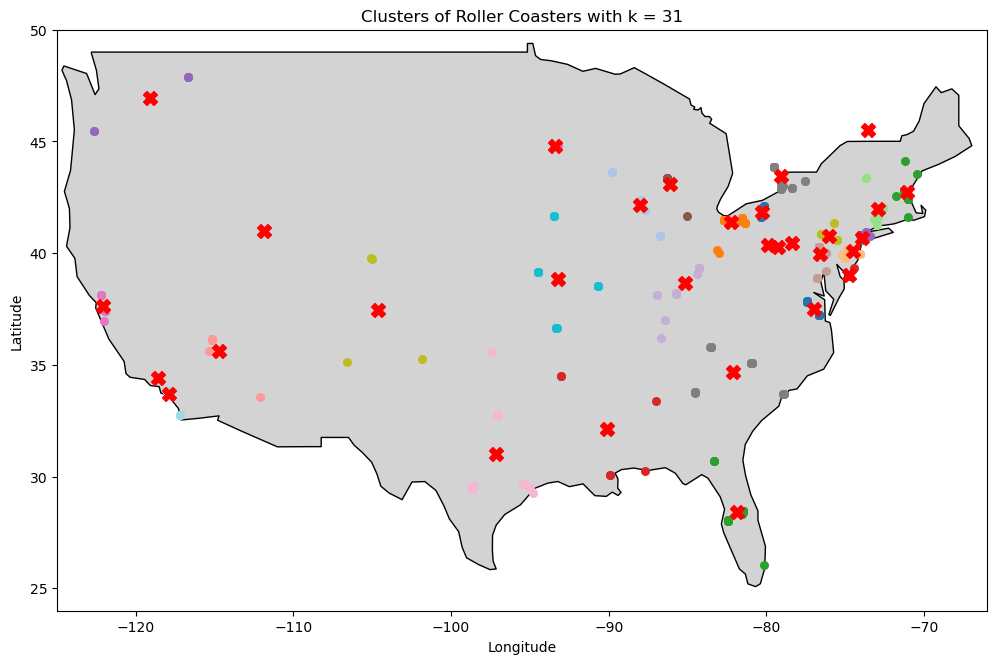

In [68]:
us_centroids_k, us_clusters_k = k_means(us_coasters_coordinates, k = 31, distance_function=euclidean_distance, max_iters = 300)

fig, ax = plt.subplots(figsize=(12, 8))
# Set bounds for continental U.S.
ax.set_xlim(-125, -66)   # Longitude
ax.set_ylim(24, 50)      # Latitude
usa.plot(ax=ax, color='lightgray', edgecolor='black')
plot_clusters(us_coasters_coordinates, us_clusters_k, us_centroids_k)
plt.show()

Let's find the average number of roller coasters per cluster and create a histogram to see the distribution of cluster sizes

In [69]:
total_coasters = sum(len(cluster) for cluster in us_clusters_k)
num_clusters = len(us_clusters_k)
average_per_cluster = total_coasters / num_clusters

print(f"Average number of coasters per cluster: {average_per_cluster:.2f}")

Average number of coasters per cluster: 16.58


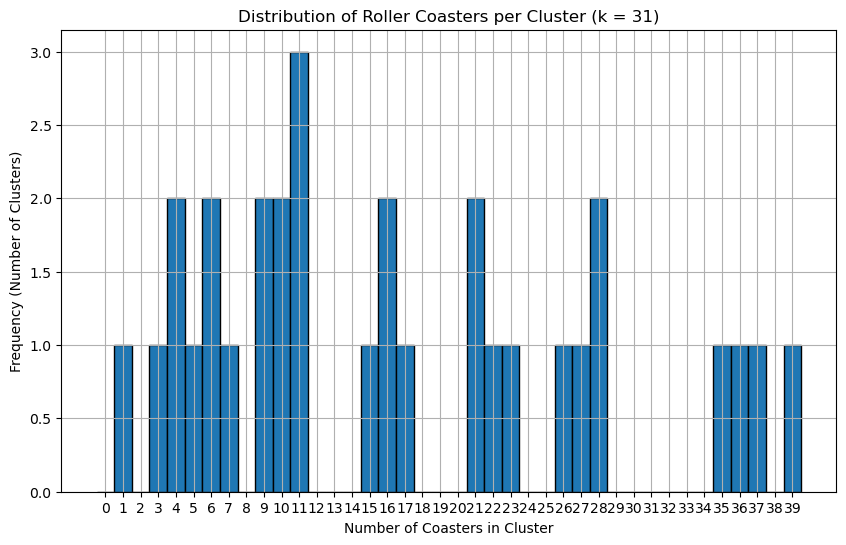

In [70]:
# Get the number of coasters in each cluster
cluster_sizes = [len(cluster) for cluster in us_clusters_k]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(cluster_sizes, bins=range(0, max(cluster_sizes) + 2), edgecolor='black', align='left')

plt.title(f'Distribution of Roller Coasters per Cluster (k = {len(us_clusters_k)})')
plt.xlabel('Number of Coasters in Cluster')
plt.ylabel('Frequency (Number of Clusters)')
plt.grid(True)
plt.xticks(range(0, max(cluster_sizes) + 1))  # one tick per possible size
plt.show()

We can see there is a fairly large range in the number of roller coasters per cluster. 11 coasters in a cluster is the most common but the frequency is 3, which is not that high.

Now, let's suppose I want to go on a road trip where I leave from Rice want to hit up the nearest cluster of roller coasters. From Google, I know that Rice's latitude and longitude is 29.7168° N, 95.4036° W.

In [82]:
rice_location = np.array([-95.4036, 29.7168])

# Calculate distances to each centroid
distances = [euclidean_distance(rice_location, centroid) for centroid in us_centroids_k]

# Find the index of the closest centroid
closest_index = np.argmin(distances)
closest_centroid = us_centroids_k[closest_index]
closest_cluster = us_clusters_k[closest_index] 
print(f"Coordinates of closest centroid: {closest_centroid}")

Coordinates of closest centroid: [-97.13665714  31.03274286]
[array([-97.0685,  32.7585]), array([-97.0702,  32.7557]), array([-95.407,  29.676]), array([-95.407,  29.675]), array([-95.4097,  29.6767]), array([-97.0706,  32.7589]), array([-97.0673,  32.7554]), array([-95.407,  29.675]), array([-95.4056,  29.6748]), array([-97.0731,  32.7564]), array([-96.997,  32.761]), array([-98.6099,  29.5965]), array([-97.0702,  32.7557]), array([-98.6965,  29.4523]), array([-98.613 ,  29.5991]), array([-98.6083,  29.5969]), array([-98.6961,  29.4553]), array([-98.61  ,  29.5952]), array([-97.0742,  32.7556]), array([-97.0702,  32.7557]), array([-95.0173,  29.5463]), array([-97.4405,  35.5838]), array([-97.0731,  32.7564]), array([-94.7895,  29.2858]), array([-98.6961,  29.4553]), array([-98.6085,  29.5951]), array([-98.699 ,  29.4524]), array([-97.071,  32.756])]


Now, we'll print out the name of the roller coasters you'll be hitting up on your trip!

In [84]:
#Creating a DataFrame from cluster coordinates closest to Rice
cluster_coords_df = pd.DataFrame(
    closest_cluster, 
    columns=['longitude', 'latitude']  # Match the column names in cleaned_data
)

# Round to reduce floating point noise
cleaned_data_rounded = cleaned_data.copy()
cleaned_data_rounded['longitude'] = cleaned_data_rounded['longitude'].round(4)
cleaned_data_rounded['latitude'] = cleaned_data_rounded['latitude'].round(4)
cluster_coords_df = cluster_coords_df.round(4)

# Merge together to get coaster names
matched_coasters = pd.merge(cluster_coords_df, cleaned_data_rounded, on=['longitude', 'latitude'], how='inner')

# Extract names and ensure no duplicates
coaster_names = list(set(matched_coasters['coaster_name'].tolist()))

#Print the names
for name in coaster_names:
    print(name)

Iron Shark
New Texas Giant
Runaway Mountain
Excalibur (Six Flags AstroWorld)
Wave Breaker: The Rescue Coaster
Shock Wave (Six Flags Over Texas)
Wile E. Coyote's Grand Canyon Blaster
XLR-8
Boardwalk Bullet
Steel Lasso
Wonder Woman Golden Lasso Coaster
The Great White (SeaWorld San Antonio)
Texas Giant
Streamliner Coaster
Judge Roy Scream
Road Runner Express (Six Flags Fiesta Texas)
Aquaman: Power Wave
Superman: Krypton Coaster
Poltergeist (roller coaster)
Sky Screamer (Six Flags AstroWorld)
Runaway Mine Train (Six Flags Over Texas)
Pipeline Express
Steel Eel
Mini Mine Train (Six Flags Over Texas)
Texas Cyclone
Titan (Six Flags Over Texas)
Texas Stingray
Serpent (roller coaster)


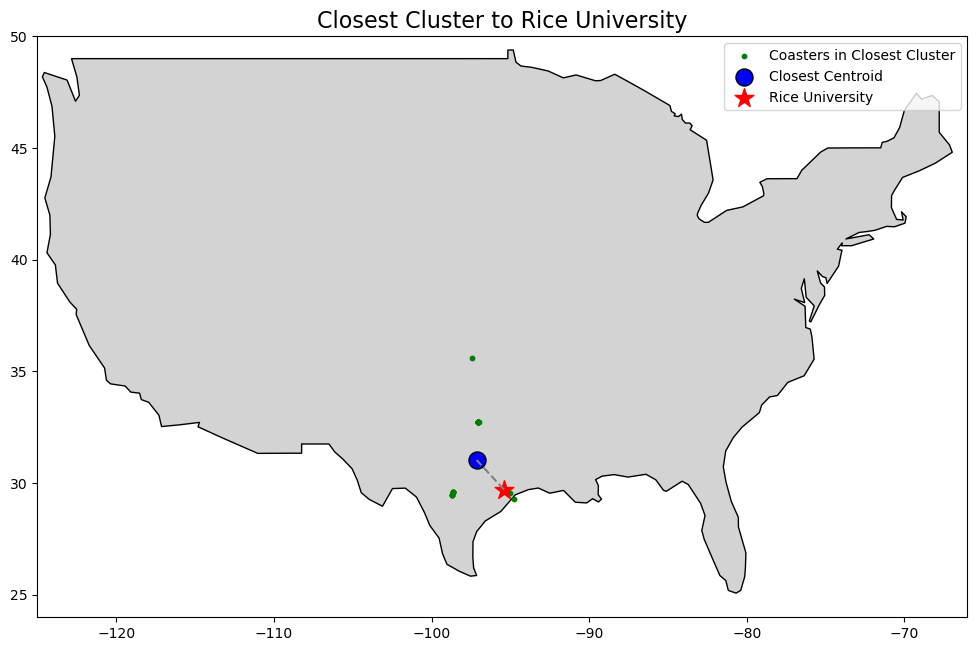

In [85]:
fig, ax = plt.subplots(figsize=(12, 8))

# Set bounds for continental U.S.
ax.set_xlim(-125, -66)   # Longitude
ax.set_ylim(24, 50)      # Latitude

#Plot USA background 
usa.plot(ax=ax, color='lightgray', edgecolor='black')

#Plot coasters in closest cluster to Rice
closest_cluster_np = np.array(closest_cluster)  
ax.scatter(
    closest_cluster_np[:, 0], closest_cluster_np[:, 1],
    color='green', label='Coasters in Closest Cluster', s=10
)

# Plot centroid
ax.scatter(
    closest_centroid[0], closest_centroid[1],
    color='blue', edgecolor='black', s=150, marker='o', label='Closest Centroid'
)

# Plot Rice
ax.scatter(
    rice_location[0], rice_location[1],
    color='red', marker='*', s=200, label="Rice University"
)

# Optional: Line connecting Rice to centroid
ax.plot(
    [rice_location[0], closest_centroid[0]],
    [rice_location[1], closest_centroid[1]],
    linestyle='--', color='gray'
)

# Step 7: Titles and labels
ax.set_title("Closest Cluster to Rice University", fontsize=16)
ax.legend()
plt.show()

## III. Using Cluster Distinctness to find optimal $k$

Above, we used the elbow method along with the Within-Cluster Sum of Squares metric to find a good value of $k$. However, now let's repeat our steps but with the new Cluster Distinctness (CD) method.

In [93]:

def calculate_cluster_distinctiveness(data, centroids, clusters, distance_function):
    distinctiveness = 0
    
    # Loop through each point in the data
    for i, point in enumerate(data):
        # Find the cluster the point belongs to by checking the corresponding cluster
        for j, cluster in enumerate(clusters):
            if point.tolist() in [p.tolist() for p in cluster]:
                own_centroid = centroids[j]  # Centroid for the cluster it belongs to
                break
        
        # Step 1: Calculate the average distance to other centroids
        other_centroids_distances = [
            distance_function(point, centroid) for k, centroid in enumerate(centroids) if k != j
        ]
        avg_distance_to_others = np.mean(other_centroids_distances)
        
        # Step 2: Subtract the distance to its own centroid
        own_centroid_distance = distance_function(point, own_centroid)
        
        # Add this point's distinctiveness value to the total
        distinctiveness += (avg_distance_to_others - own_centroid_distance)
    
    return distinctiveness

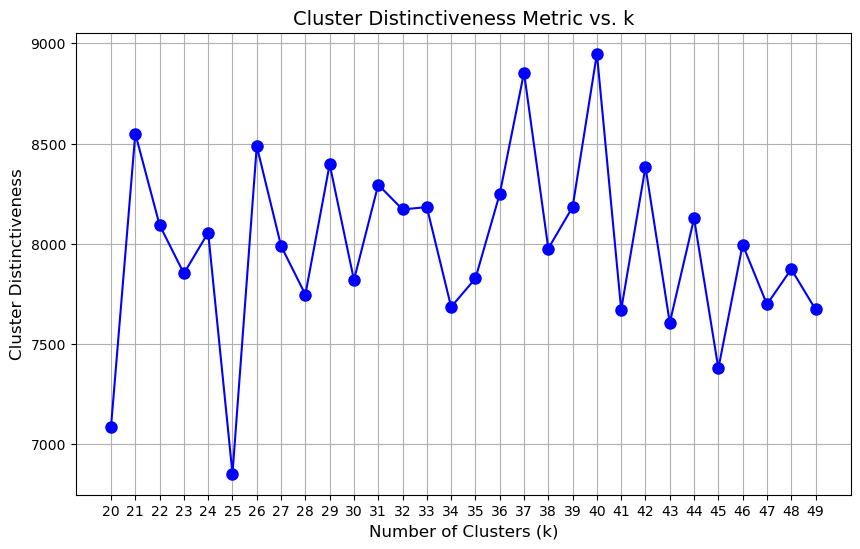

In [94]:
# Values of k to test
k_values = range(20, 50)  
distinctiveness_values = []

# Run k-means and calculate distinctiveness for each k
for k in k_values:
    centroids, clusters = k_means(us_coasters_coordinates, k, euclidean_distance, max_iters=300)
    distinctiveness = calculate_cluster_distinctiveness(us_coasters_coordinates, centroids, clusters, euclidean_distance)
    distinctiveness_values.append(distinctiveness)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, distinctiveness_values, marker='o', color='b', linestyle='-', markersize=8)
plt.title('Cluster Distinctiveness Metric vs. k', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Cluster Distinctiveness', fontsize=12)
plt.grid(True)
plt.xticks(k_values)  # To show every k value on x-axis
plt.show()

We see that $k$ = 40 gives us the highest cluster distinctiveness value. Now, let's redo our clustering with this value of $k$ instead.

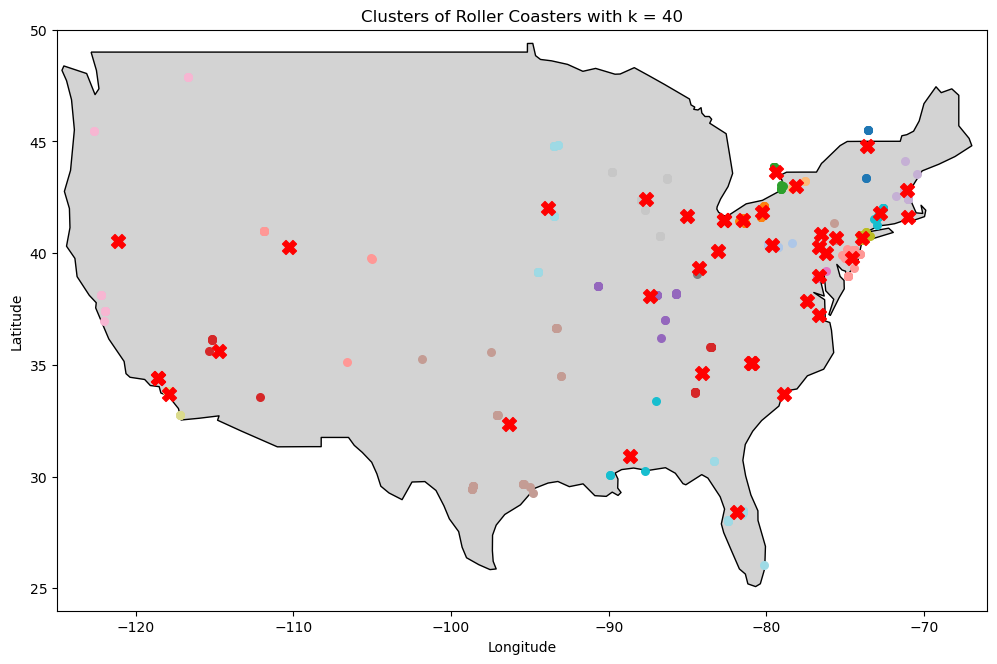

In [95]:
us_centroids_k, us_clusters_k = k_means(us_coasters_coordinates, k = 40, distance_function=euclidean_distance, max_iters = 300)

fig, ax = plt.subplots(figsize=(12, 8))
# Set bounds for continental U.S.
ax.set_xlim(-125, -66)   # Longitude
ax.set_ylim(24, 50)      # Latitude
usa.plot(ax=ax, color='lightgray', edgecolor='black')
plot_clusters(us_coasters_coordinates, us_clusters_k, us_centroids_k)
plt.show()